## Classifier Construction and Candidate Predictions

**Authors**: Aaron Liu, Rahul Venkatesh, Martha Grover, Carson Meredith, Elsa Reichmanis

This code uses the best features from the "Feature Selection" notebook to construct classifiers, compute their performance (ROC-AUC), and predict the performance of new molecules using a subset of the eMolecules dataset. The whole dataset can be found here: https://downloads.emolecules.com/free/2020-06-01/

For our study, we downloaded and extracted from the compressed .smi file (version.smi.gz). Since the file contains a huge number of molecules (>1.4 GB), we wrote the first ~10,000 molecules into a separate .txt file (see Data folder)

In [1]:
#Import libraries
import pylab as plt
import numpy as np
import pandas as pd

In [2]:
#Import file
filename1 = 'data/PETadditives_database_and_descriptors.csv'
filename2 = 'data/MACCS_keys_PETadditives corrected.csv'
df_alvadesc = pd.read_csv(filename1)
df_maccs = pd.read_csv(filename2)

#Apply dataset-specific filtering
def filter_dataset(df):
    
    criteria1 = df['Addition Method']=="A"
    criteria2 = df['Amount Added']==0.25
    df_filtered = df[criteria1&criteria2]
    df_filtered = df_filtered.sort_values(by=['wet 3 day'])
    response = "wet 3 day"
    y = df_filtered[response].values
    X = df_filtered.iloc[:,10:].values #descriptors
    df_X = df_filtered.iloc[:,10:]
    molecules = df_filtered['NAME']
    
    return df_X, molecules, X, y

df_Xad, molecules, Xad, y = filter_dataset(df_alvadesc)
df_Xm, _, Xm, _ = filter_dataset(df_maccs) 

# #Apply scaling
# scaler = MinMaxScaler()
# df_Xad[:] = scaler.fit_transform(df_Xad)

#Assign labels based on a threshold
critical_threshold = 64
labels = y>critical_threshold

We will choose the best three features (identified from report and discussion); other features may be included if one wishes to test the performance for other subsets

In [3]:
# Choose "best feature columns" for alvadesc/MACCS datasets

rdr_ad_bestfeatures = [
                    # 'BIC4',
                    # 'BIC5',
                    # 'CIC3',
                    # 'CIC4',
                    # 'CIC5',
                    # 'Eta_sh_p',
                    'GATS4i',
                    # 'GATS6e',
                    # 'GATS6s', 
                    # 'H-047',
                    # 'JGI4',
                    # 'MATS1e',
                    # 'MATS2v',
                    # 'MATS6s',
                    # 'P_VSA_ppp_L',
                    # 'SIC3',
                    'SIC4',
                    # 'SIC5'
                    ]
rdr_maccs_bestfeatures = [ 
                    'MACCSFP92',
                    'MACCSFP98',
                    'MACCSFP162'
                    ]

df_Xad_best = df_Xad.copy()[rdr_ad_bestfeatures]

df_Xm_best = df_Xm.copy()[rdr_maccs_bestfeatures]

Helper function computes a confusion matrix along with several classification metrics. We do not use them to generally make decisions here, but they are available if the reader is interested:

In [4]:
def compute_cm_scores(y_test,y_predict):
    cm_ = confusion_matrix(y_test,y_predict)
    tn_, fp_, fn_, tp_ = cm_.ravel()    
    acc_ = (tp_ + tn_)/(tp_ + tn_ + fp_ + fn_)
    prec_ = tp_/(tp_ + fp_)
    recall_ = tp_/(tp_ + fn_)
    f1_ = (2*prec_*recall_)/(prec_ + recall_)
    
    return cm_, acc_, prec_, recall_, f1_

### Hyperparameter Tuning

This block is for hyperparameter tuning; but by default it is presented here we just the hyperparameters set to decrease the running time of the notebook. 

In [5]:
# Random Forest: Hyperparameter tuning
        
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#train-test split for hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(df_Xm.values, labels, test_size=0.1,stratify=labels)

#Uncomment below for hyperparameter tuning, but it may take a long time to run
"""
#Perform GridSearchCV to find local optimum hyperparameters
rforest=RandomForestClassifier()
parameter_ranges = {
                    'max_depth':range(4,20,4),
                    'n_estimators':range(50,200,4)
                    }
rforest_search = GridSearchCV(rforest,parameter_ranges,iid=False)
rforest_search.fit(df_Xm.values,labels)

#Store best hyperparameters
max_depth = rforest_search.best_params_['max_depth']
n_estimators = rforest_search.best_params_['n_estimators']
"""

#Hyperparameters that work well are here:
max_depth = 12
n_estimators = 100

### Construction of Random Forest Classifiers 

The subsequent code blocks construct random forest classifiers for each feature subset and calculate the ROC-AUC score. Each model here incorporates leave-one-out cross validation to compute the probability scores and testing metrics. First, using the three best MACCS-166 keys:

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

ym_test = np.array([])
ym_predict = np.array([])
y_predict_proba = np.array([])

for train_index, test_index in loo.split(df_Xm_best):

    X_train, X_test = df_Xm_best.iloc[train_index], df_Xm_best.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Compute i'th RF model
    RF = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
    RF.fit(X_train, y_train)
    
    # Predict i'th test set
    y_predict_i = RF.predict(X_test)
    
    # Extract class probabilities (for True case)
    y_predict_proba_i = RF.predict_proba(X_test)
    
    #Append current iteration of predictions and test
    ym_predict = np.append(ym_predict,y_predict_i)
    ym_test = np.append(ym_test,y_test)
    y_predict_proba = np.append(y_predict_proba, y_predict_proba_i[0][1])

#Other classification metrics are here, if the reader is interested
cm_rdr_maccs, acc_rdr_m, prec_rdr_m, recall_rdr_m, f1_rdr_m = compute_cm_scores(ym_test, ym_predict)

#Calculate ROC-AUC
auc_rf3_m = roc_auc_score(ym_test,y_predict_proba)
fpr_rf3_m, tpr_rf3_m, thresholds = roc_curve(ym_test,y_predict_proba)

print('\nROC-AUC: {:.3E}'.format(auc_rf3_m))


ROC-AUC: 7.742E-01


Using all available MACCS-166 keys:

In [7]:
ym_test = np.array([])
ym_predict = np.array([])
y_predict_proba = np.array([])

for train_index, test_index in loo.split(df_Xm):

    X_train, X_test = df_Xm.iloc[train_index], df_Xm.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Compute i'th RF model
    RF = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
    RF.fit(X_train, y_train)
    
    # Predict i'th test set
    y_predict_i = RF.predict(X_test)
    
    # Extract class probabilities (for True case)
    y_predict_proba_i = RF.predict_proba(X_test)
    
    #Append current iteration of predictions and test
    ym_predict = np.append(ym_predict,y_predict_i)
    ym_test = np.append(ym_test,y_test)
    y_predict_proba = np.append(y_predict_proba, y_predict_proba_i[0][1])

#Other classification metrics are here, if the reader is interested
cm_rf_maccs, acc_rf_m, prec_rf_m, recall_rf_m, f1_rf_m = compute_cm_scores(ym_test, ym_predict)

#Calculate ROC-AUC
auc_rf166_m = roc_auc_score(ym_test,y_predict_proba)
fpr_rf166_m, tpr_rf166_m, thresholds = roc_curve(ym_test,y_predict_proba)
print('\nROC-AUC: {:.3E}'.format(auc_rf166_m))


ROC-AUC: 8.508E-01


Next, we perform the same on the alvaDesc features; first with the three best features (by default, SIC4, GATS4i, GATS6s):

In [8]:
ym_test = np.array([])
ym_predict = np.array([])
y_predict_proba = np.array([])

for train_index, test_index in loo.split(df_Xad_best):

    X_train, X_test = df_Xad_best.iloc[train_index], df_Xad_best.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Compute i'th RF model
    RF = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
    RF.fit(X_train, y_train)
    
    # Predict i'th test set
    y_predict_i = RF.predict(X_test)
    
    # Extract class probabilities (for True case)
    y_predict_proba_i = RF.predict_proba(X_test)
    
    #Append current iteration of predictions and test
    ym_predict = np.append(ym_predict,y_predict_i)
    ym_test = np.append(ym_test,y_test)
    y_predict_proba = np.append(y_predict_proba, y_predict_proba_i[0][1])


# ROC Curve, ROC-AUC metrics

#For ROC Curve
auc_rf3_ad = roc_auc_score(ym_test,y_predict_proba)
fpr_rf3_ad, tpr_rf3_ad, thresholds = roc_curve(ym_test,y_predict_proba)


print('\nROC-AUC: {:.3E}'.format(auc_rf3_ad))


ROC-AUC: 9.435E-01


Now, using all 1875 features:

In [9]:
ym_test = np.array([])
ym_predict = np.array([])
y_predict_proba = np.array([])

for train_index, test_index in loo.split(df_Xad):

    X_train, X_test = df_Xad.iloc[train_index], df_Xad.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Compute i'th RF model
    RF = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
    RF.fit(X_train, y_train)
    
    # Predict i'th test set
    y_predict_i = RF.predict(X_test)
    
    # Extract class probabilities (for True case)
    y_predict_proba_i = RF.predict_proba(X_test)
    
    #Append current iteration of predictions and test
    ym_predict = np.append(ym_predict,y_predict_i)
    ym_test = np.append(ym_test,y_test)
    y_predict_proba = np.append(y_predict_proba, y_predict_proba_i[0][1])

auc_rf1875_ad = roc_auc_score(ym_test,y_predict_proba)
fpr_rf1875_ad, tpr_rf1875_ad, thresholds = roc_curve(ym_test,y_predict_proba)    

print('\nROC-AUC: {:.3E}'.format(auc_rf1875_ad))


ROC-AUC: 6.613E-01


### Performance Comparison

Here, we will use ROC curves to evaluate the performance for both descriptor sets:

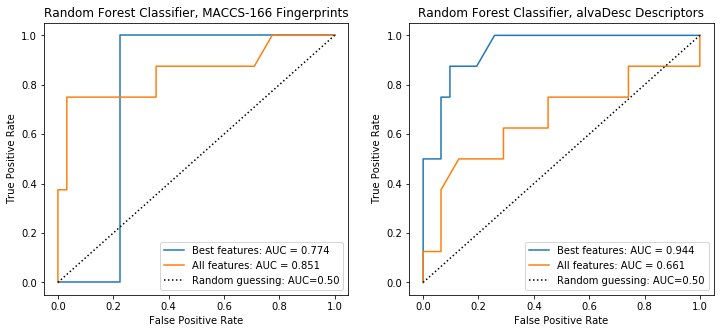

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,5))


ax[0].plot(fpr_rf3_m,tpr_rf3_m)
ax[0].plot(fpr_rf166_m,tpr_rf166_m)
ax[0].plot(np.linspace(0,1),np.linspace(0,1),'k:')
ax[0].set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='Random Forest Classifier, MACCS-166 Fingerprints')
ax[0].legend(['Best features: AUC = {:.3}'.format(auc_rf3_m),
           'All features: AUC = {:.3}'.format(auc_rf166_m),
           'Random guessing: AUC=0.50']);


ax[1].plot(fpr_rf3_ad, tpr_rf3_ad, label='RF-alvadesc, 2 features')
ax[1].plot(fpr_rf1875_ad,tpr_rf1875_ad, label='RF-alvadesc, all features')
ax[1].plot(np.linspace(0,1),np.linspace(0,1),'k:')
ax[1].set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='Random Forest Classifier, alvaDesc Descriptors')
ax[1].legend(['Best features: AUC = {:.3}'.format(auc_rf3_ad),
           'All features: AUC = {:.3}'.format(auc_rf1875_ad),
           'Random guessing: AUC=0.50']);

Above, the MACCS-166 set does not improve when using the three best features; in fact, we see that we need information; though using all 166 does not appear to cause overfitting. This isn't too surprising, as we see in the *Feature Selection* notebook that the chemical groups identified are indicative of good performance, but not an absolute criterion for this dataset, as other low performers have those characteristics.

On the other hand, in the alvaDesc descriptors, we saw that we can achieve complete class separation with only 2 features. This could be a consequence of a small dataset, but the performance evaluated above was based on cross validation -- therefore none of the above points have seen the model. 1,875 features is an expansive feature space, and it appears to cause severe overfitting. Guiding the predictor with feature selection appears to be more effective.

## New Candidate Predictions - MACCS-166

Now, we will incorporate the eMolecules dataset to suggest a set of novel predictions:

In [11]:
#Import emolecules database subset (10,000 molecules)
filename = 'data/emolecules_1-10000_MACCS.txt'
df = pd.read_csv(filename, delimiter="\t",index_col='NAME')
df_Xm_candidates = df.iloc[:,1:] #The first column contains an index; we will include only the MACCSFP's

#Total number of candidates in this try
print('Shape of candidates matrix: {}'.format(df_Xm_candidates.shape))
df_Xm_candidates.head()

Shape of candidates matrix: (9999, 166)


,MACCSFP1,MACCSFP2,MACCSFP3,MACCSFP4,MACCSFP5,MACCSFP6,MACCSFP7,MACCSFP8,MACCSFP9,MACCSFP10,...,MACCSFP157,MACCSFP158,MACCSFP159,MACCSFP160,MACCSFP161,MACCSFP162,MACCSFP163,MACCSFP164,MACCSFP165,MACCSFP166
NAME,,,,,,,,,,,,,,,,,,,,,
CO[C@@H]1CCCC[C@H]1O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
OC(COCC=C)c1ccccc1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
CCOC(C)c1ccccc1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0
CC1OCCC(C)=C1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,1,0
ClCCNc1ccccc1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0


Construct the RF model using all data points and MACCS-166 keys:

In [12]:
RF_maccs166 = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
RF_maccs166.fit(df_Xm, labels)

# Predictions on new candidates
result = RF_maccs166.predict(df_Xm_candidates)
scores = RF_maccs166.predict_proba(df_Xm_candidates)

candidate_ranks_maccs = pd.DataFrame(scores[:,1],index=df_Xm_candidates.index)
positive_candidates_maccs = df_Xm_candidates[result]

candidate_ranks_maccs.sort_values(0,ascending=False).head(10)

,0
NAME,
CCOC(=O)C(C(C)=O)C(=O)CN1C(=O)c2ccccc2C1=O,0.88
CC(=O)Nc1ccc(OCCCN2C(=O)c3ccccc3C2=O)cc1,0.85
COc1ccc(OCCCN2C(=O)c3ccccc3C2=O)cc1,0.83
OC(CN1C(=O)c2ccccc2C1=O)CN1C(=O)c2ccccc2C1=O,0.83
CCOC(=O)Cn1c(=O)[nH]c2sc3CCCc3c2c1=O,0.82
OCCCN1C(=O)CCC1=O,0.81
Fc1ccccc1OCC(=O)N1CCC(C1)C(=O)NCCc1ccccc1,0.80
CCCOc1ccc(cc1)C(=O)Nc1ccc(C)c(Cl)c1,0.79
COc1ccc(OC)c(CCN2C(=O)c3ccccc3C2=O)c1,0.79


Above, we sort the candidate predictions by their score in the model, rather than using the assigned class label (which assumes all probabilities above a default threshold of 0.50 are "high"). This allows us to actually rank the molecules in terms of how well they performed in the model. These SMILES strings can be visualized through other python modules, or other resources such as PubChem or ChemDraw.

## New Candidate Predictions - alvaDesc

The alvaDesc descriptors were calculated for all ~10,000 molecules (in the alvaDesc software, this typically takes about 5-10 minutes or less depending on the computation power of the computer. Generally, it is relatively fast).

Here, there may be some missing values for certain descriptors, so we can filter them out as an extra step.


In [13]:
import warnings
warnings.filterwarnings("ignore") #avoid pandas dtype warning here...

filename = 'data\emolecules_1-10000_MDs.txt'
df = pd.read_csv(filename, delimiter="\t",index_col='NAME')
df_Xad_candidates = df[rdr_ad_bestfeatures]

#Remove 'na' values inputted by alvaDesc .txt output
mask = np.all(df_Xad_candidates.apply(lambda x: x!='na'),axis=1)
df_Xad_candidates = df_Xad_candidates[mask]

print(df_Xad_candidates.shape)
df_Xad_candidates.head()

(9963, 3)


,GATS4i,GATS6s,SIC4
NAME,,,
CO[C@@H]1CCCC[C@H]1O,0.951137,0.0490183,0.838960
OC(COCC=C)c1ccccc1,1.016236,0.938844,0.890950
CCOC(C)c1ccccc1,1.276593,0.713078,0.831952
CC1OCCC(C)=C1,1.192349,0,0.843707
ClCCNc1ccccc1,1.033820,1.2653,0.861173


Construct the RF model using all data points and the best three alvaDesc descriptors:

In [14]:
RF_alvadesc3 = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
RF_alvadesc3.fit(df_Xad_best, labels)

# Predictions on new candidates
result = RF_alvadesc3.predict(df_Xad_candidates)
scores = RF_alvadesc3.predict_proba(df_Xad_candidates)
candidate_ranks_alvadesc = pd.DataFrame(scores[:,1],index=df_Xad_candidates.index)

positive_candidates_alvadesc = df_Xad_candidates[result]

As before, the top performers based on classification probability:

In [15]:
candidate_ranks_alvadesc.sort_values(0,ascending=False).head(10)

,0
NAME,
COc1ccccc1NC(=O)c1cnc(nc1C)C1CCN(CC1)C(=O)CN1CCCC1,0.98
NC(=O)C1(Cc2ccc(cc2)-c2ccccc2)CCN(CC1)C(=O)Cc1ccccc1,0.97
CCN(CC)C(=O)c1c[nH]nc1C1CCN(CC1)C(=O)CCc1cn(C)c2ccccc12,0.97
CC(=O)Oc1ccc(cc1)C(=O)Cc1ccccc1,0.97
Cc1nc(ccc1C(N)=O)[C@H]1CC[C@H](CNC(=O)CN2CCC(CC2)c2ccccc2)CC1,0.96
CCC(=O)N1CCC(CC1)c1nnc(o1)C1CCCCN1C(=O)COc1ccccc1,0.96
CCC(CNC(=O)C1(Cc2ccc(cc2)-c2ccncc2)CCOCC1)OC,0.95
NC(=O)C1(Cc2ccc(cc2)-c2ccccc2)CCN(CC1)C(=O)CCc1ccccc1,0.95
COc1ccc(C)cc1CC(=O)N1CCC(CC1)c1n[nH]cc1C(=O)N1CCOCC1,0.95
